# Role of time-aware and similarity-aware splits

This notebook analyzes the differences between the proposed split (either time-aware or similarity-aware) and the random split. The results are shown and described in the accompanying paper.

In [1]:
import sys
sys.path.insert(0, '../..')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import pickle
from sklearn.metrics import auc
from wildlife_datasets.datasets import WildlifeReID10k
from wildlife_datasets.splits import BalancedSplit
from wildlife_datasets.metrics import BAKS, BAUS
from wildlife_datasets.splits import BalancedSplit
from utils import compute_predictions, make_radar_plot, mean

In [2]:
root_data = '/data/wildlife_datasets/data/WildlifeReID10k'
root_images = os.path.join(root_data, 'images')
save_clusters_prefix = 'clusters/cluster'
d = WildlifeReID10k(root_data)
d.df['date'] = pd.to_datetime(d.df['date'])

In [3]:
splitter = BalancedSplit(seed=666)

idx_test = []
for name, df_dataset in d.df.groupby('dataset'):
    df_train = df_dataset[df_dataset['split'] == 'train']
    df_test = df_dataset[df_dataset['split'] == 'test']
    _, idx = splitter.resplit_random(df_dataset, df_train.index, df_test.index)
    idx_test = idx_test + list(idx)

d.df['split_similarity'] = d.df['split']
d.df['split_random'] = 'train'
d.df.loc[idx_test, 'split_random'] = 'test'

for _, df_identity in d.df.groupby('identity'):
    sum1 = sum(df_identity['split_similarity'] == 'test')
    sum2 = sum(df_identity['split_random'] == 'test')
    sum3 = sum(df_identity['split_similarity'] == 'train')
    sum4 = sum(df_identity['split_random'] == 'train')
    if sum1 != sum2 or sum3 != sum4:
        raise Exception('Number of images is wrong')

In [4]:
roots = ['features_mega', 'features_miew']
cols = ['split_similarity', 'split_random']
file_name = 'results/results.pickle'

step = 0.01
ts = [-np.inf] + list(np.arange(0, 1+step/10, step)) + [np.inf]
new_individual = 'new_individual'

baks = {root: {col: {t: {} for t in ts} for col in cols} for root in roots}
baus = {root: {col: {t: {} for t in ts} for col in cols} for root in roots}
if not os.path.exists(file_name):
    for root in roots:
        for col in cols:
            result = {}
            for name, df_dataset in d.df.groupby('dataset'):
                print(name)
                features = np.load(f'{root}/features_{name}.npy')

                idx_train = np.where(df_dataset[col] == 'train')[0]
                idx_test = np.where(df_dataset[col] == 'test')[0]

                idx_true, idx_pred, similarity = compute_predictions(features[idx_test], features[idx_train], return_score=True)
                idx_true = idx_test[idx_true]
                idx_pred = idx_train[idx_pred]
                idx_pred = idx_pred[:,0]
                similarity = similarity[:,0]

                y_true = df_dataset['identity'].iloc[idx_true]
                y_pred_closed = df_dataset['identity'].iloc[idx_pred]

                identity_test_only = list(set(df_dataset['identity'].iloc[idx_test]) - set(df_dataset['identity'].iloc[idx_train]))

                for t in ts:
                    y_pred = copy.copy(y_pred_closed)
                    with np.errstate(invalid='ignore'):
                        y_pred[similarity < t] = new_individual
                    baks[root][col][t][name] = BAKS(y_true, y_pred, identity_test_only)
                    baus[root][col][t][name] = BAUS(y_true, y_pred, identity_test_only, new_individual)
    with open(file_name, 'wb') as handle:
        pickle.dump([baks, baus], handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open(file_name, 'rb') as handle:
        baks, baus = pickle.load(handle)     

In [5]:
names_trained = [
    'AAUZebraFish',
    'AerialCattle2017',
    'ATRW',
    'BelugaID',
    'BirdIndividualID',
    'CTai',
    'CZoo',
    'Cows2021',
    'FriesianCattle2015',
    'FriesianCattle2017',
    'GiraffeZebraID',
    'Giraffes',
    'HyenaID2022',
    'IPanda50',
    'LeopardID2022',
    'NDD20',
    'NyalaData',
    'OpenCows2020',
    'SealID',
    'SeaTurtleID2022',
    'SMALST',
    'StripeSpotter',
    'WhaleSharkID',
    'ZindiTurtleRecall',
]
names_time_split = [
    'BelugaID',
    'BirdIndividualID',
    'CowDataset',
    'Cows2021',
    'GiraffeZebraID',
    'Giraffes',
    'MultiCamCows2024',
    'SeaStarReID2023',
    'SeaTurtleID2022',
]
names_non_trained = list(set(d.df['dataset'].unique()) - set(names_trained))
names_similarity_split = list(set(d.df['dataset'].unique()) - set(names_time_split))

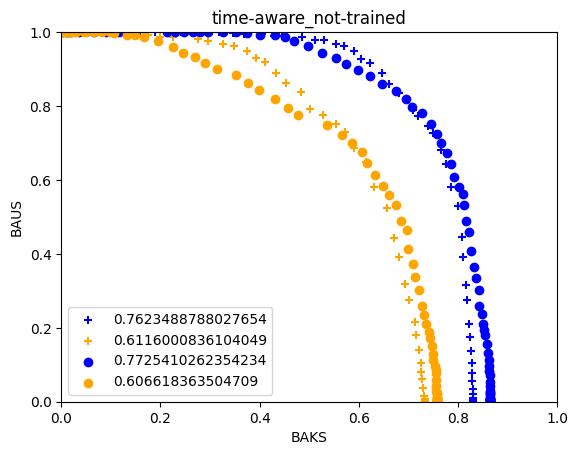

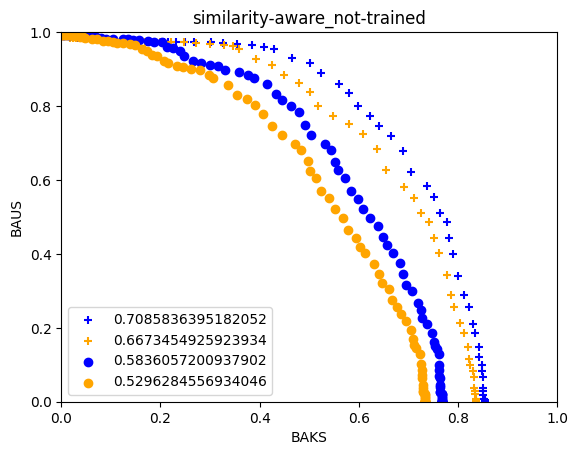

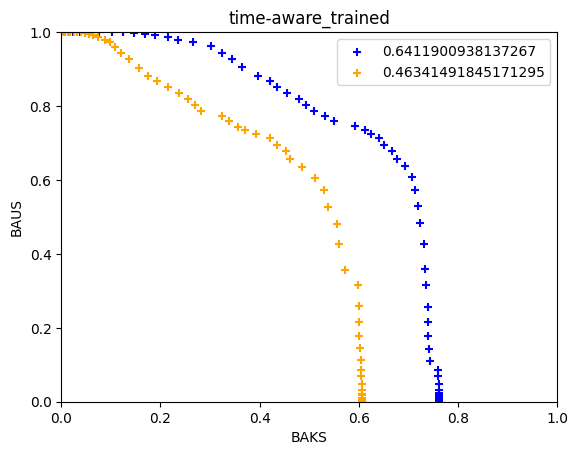

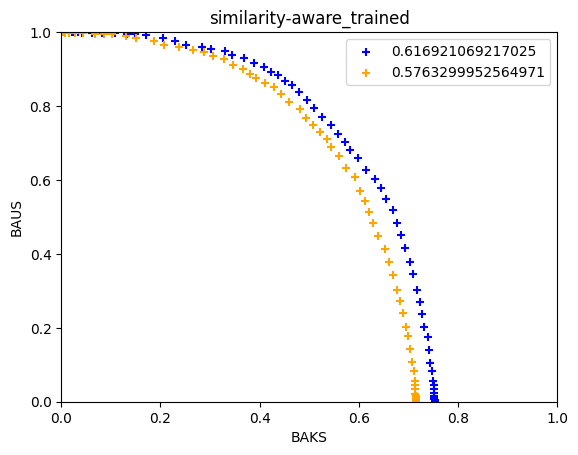

In [6]:
idx = names_time_split
idx = names_trained

idx_all = [
    list(set(names_non_trained).intersection(names_time_split)),
    list(set(names_non_trained).intersection(names_similarity_split)),
    list(set(names_trained).intersection(names_time_split)),
    list(set(names_trained).intersection(names_similarity_split)),
]
titles = [
    'time-aware_not-trained',
    'similarity-aware_not-trained',
    'time-aware_trained',
    'similarity-aware_trained',
]

for i, (idx, title) in enumerate(zip(idx_all, titles)):
    legend = []
    plt.figure()
    data1 = [mean(baks['features_miew']['split_random'][t], idx=idx) for t in ts]
    data2 = [mean(baus['features_miew']['split_random'][t], idx=idx) for t in ts]
    plt.scatter(data1, data2, color='blue', marker='+')
    legend.append(auc(data1, data2))
    data1 = [mean(baks['features_miew']['split_similarity'][t], idx=idx) for t in ts]
    data2 = [mean(baus['features_miew']['split_similarity'][t], idx=idx) for t in ts]    
    plt.scatter(data1, data2, color='orange', marker='+')
    legend.append(auc(data1, data2))    
    if i < 2:
        data1 = [mean(baks['features_mega']['split_random'][t], idx=idx) for t in ts]
        data2 = [mean(baus['features_mega']['split_random'][t], idx=idx) for t in ts]
        plt.scatter(data1, data2, color='blue', marker='o')
        legend.append(auc(data1, data2))
        data1 = [mean(baks['features_mega']['split_similarity'][t], idx=idx) for t in ts]
        data2 = [mean(baus['features_mega']['split_similarity'][t], idx=idx) for t in ts]
        plt.scatter(data1, data2, color='orange', marker='o')
        legend.append(auc(data1, data2))        
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('BAKS')
    plt.ylabel('BAUS')
    plt.title(title)
    plt.legend(legend)

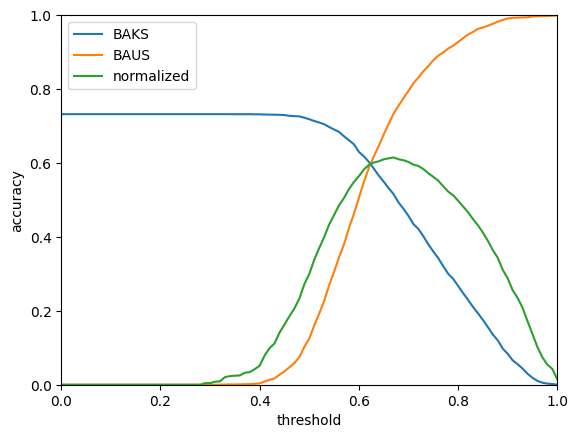

In [7]:
data_baks = np.array([mean(baks['features_miew']['split_similarity'][t]) for t in ts])
data_baus = np.array([mean(baus['features_miew']['split_similarity'][t]) for t in ts])
data_normalized = np.sqrt(data_baks*data_baus)

plt.plot(ts, data_baks, label='BAKS')
plt.plot(ts, data_baus, label='BAUS')
plt.plot(ts, data_normalized, label='normalized')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('threshold')
plt.ylabel('accuracy')
plt.legend()
pd.DataFrame({
    't': ts[1:-1],
    'BAKS': data_baks[1:-1],
    'BAUS': data_baus[1:-1],
    'normalized': data_normalized[1:-1],
}).to_csv('results/normalized.csv', index=False)

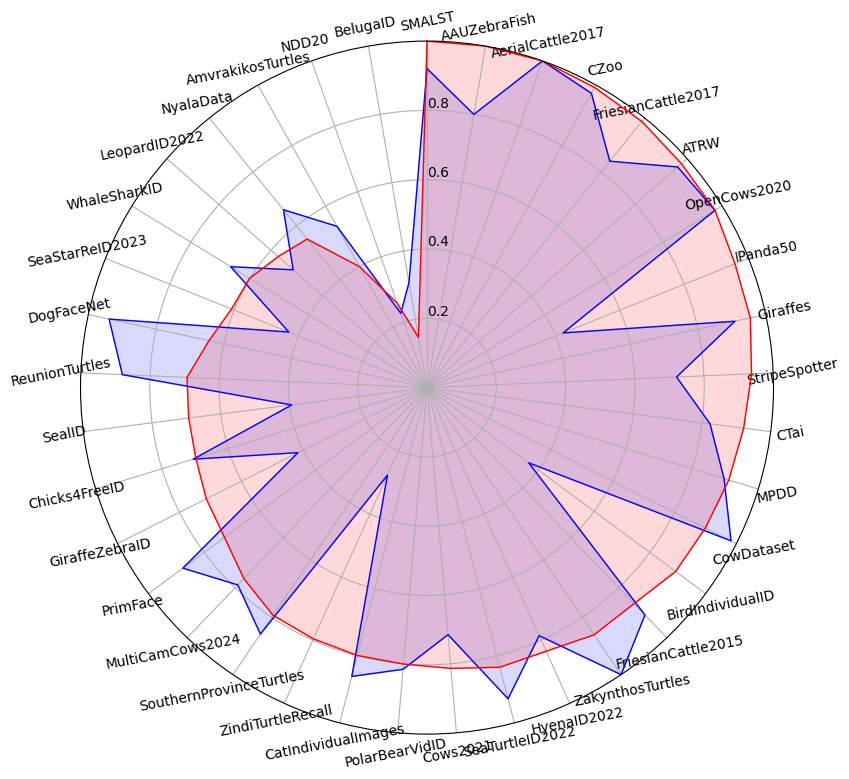

In [8]:
results_closed = pd.DataFrame({
    'miew': baks['features_miew']['split_similarity'][np.min(ts)],
    'mega': baks['features_mega']['split_similarity'][np.min(ts)],
})
results_closed = results_closed.sort_values('mega', ascending=False)

make_radar_plot(results_closed, 'blue', use_col='miew')
make_radar_plot(results_closed, 'red', use_col='mega', fontsize=10, rotation=11)

plt.savefig('results/performance.png', bbox_inches='tight', dpi=600)